# **Практика 2**

# **Book Crossing Dataset**

# 1. Сбор данных для рекомендаций

In [4]:
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer

books = pd.read_csv("BX-Books.csv", sep=";", encoding="latin-1", quotechar='"', on_bad_lines="skip", low_memory=False)
users = pd.read_csv("BX-Users.csv", sep=";", encoding="latin-1", quotechar='"', on_bad_lines="skip", low_memory=False)
ratings = pd.read_csv("BX-Book-Ratings.csv", sep=";", encoding="latin-1", quotechar='"', on_bad_lines="skip", low_memory=False)

print(f"Книги: {books.shape}")
print(f"Пользователи: {users.shape}")
print(f"Рейтинги: {ratings.shape}")

Книги: (271360, 8)
Пользователи: (278858, 3)
Рейтинги: (1149780, 3)


In [5]:
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [7]:
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2


In [8]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [9]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [10]:
books.at[117770 ,'Book-Author'] = 'Other'
books.at[118033 ,'Book-Author'] = 'Other'
books.at[187689 ,'Book-Author'] = 'Other'

books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [11]:
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,0
Year-Of-Publication,0
Publisher,0


In [12]:
books['Year-Of-Publication'].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', 'DK Publishing Inc', 'Gallimard', '1909',
       

In [13]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [14]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [15]:
books.at[209538, 'Publisher'] = 'DK Publishing Inc'
books.at[209538, 'Year-Of-Publication'] = 2000
books.at[209538, 'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538, 'Book-Author'] = 'Michael Teitelbaum'

books.at[221678, 'Publisher'] = 'DK Publishing Inc'
books.at[221678, 'Year-Of-Publication'] = 2000
books.at[221678, 'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[221678, 'Book-Author'] = 'James Buckley'

books.at[220731, 'Publisher'] = 'Gallimard'
books.at[220731, 'Year-Of-Publication'] = 2003
books.at[220731, 'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers'
books.at[220731, 'Book-Author'] = 'Jean-Marie Gustave Le Clézio'

In [16]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [17]:
print(sorted(list(books['Year-Of-Publication'].unique())))

[np.int64(0), np.int64(1376), np.int64(1378), np.int64(1806), np.int64(1897), np.int64(1900), np.int64(1901), np.int64(1902), np.int64(1904), np.int64(1906), np.int64(1908), np.int64(1909), np.int64(1910), np.int64(1911), np.int64(1914), np.int64(1917), np.int64(1919), np.int64(1920), np.int64(1921), np.int64(1922), np.int64(1923), np.int64(1924), np.int64(1925), np.int64(1926), np.int64(1927), np.int64(1928), np.int64(1929), np.int64(1930), np.int64(1931), np.int64(1932), np.int64(1933), np.int64(1934), np.int64(1935), np.int64(1936), np.int64(1937), np.int64(1938), np.int64(1939), np.int64(1940), np.int64(1941), np.int64(1942), np.int64(1943), np.int64(1944), np.int64(1945), np.int64(1946), np.int64(1947), np.int64(1948), np.int64(1949), np.int64(1950), np.int64(1951), np.int64(1952), np.int64(1953), np.int64(1954), np.int64(1955), np.int64(1956), np.int64(1957), np.int64(1958), np.int64(1959), np.int64(1960), np.int64(1961), np.int64(1962), np.int64(1963), np.int64(1964), np.int64(1

In [18]:
# Диапазон допустимых лет составляет менее 2022 года, а не 0
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002]

In [19]:
# Заменил все недопустимые годы на средний год публикаций, на 2002 год
books.loc[books['Year-Of-Publication'] > 2021, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [20]:
# Преобразование всех букв в столбце ISBN в верхний регистр
books['ISBN'] = books['ISBN'].str.upper()

In [21]:
books.drop_duplicates(keep='last', inplace=True)
books.reset_index(drop = True, inplace = True)

In [22]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271047 non-null  object
 1   Book-Title           271047 non-null  object
 2   Book-Author          271047 non-null  object
 3   Year-Of-Publication  271047 non-null  int64 
 4   Publisher            271047 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [23]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


# Users Dataset Предварительная обработка

In [24]:
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [25]:
print(users.isna().sum())

User-ID          0
Location         0
Age         110762
dtype: int64


In [26]:
print(sorted(list(users['Age'].unique())))

[np.float64(nan), np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0), np.float64(25.0), np.float64(26.0), np.float64(27.0), np.float64(28.0), np.float64(29.0), np.float64(30.0), np.float64(31.0), np.float64(32.0), np.float64(33.0), np.float64(34.0), np.float64(35.0), np.float64(36.0), np.float64(37.0), np.float64(38.0), np.float64(39.0), np.float64(40.0), np.float64(41.0), np.float64(42.0), np.float64(43.0), np.float64(44.0), np.float64(45.0), np.float64(46.0), np.float64(47.0), np.float64(48.0), np.float64(49.0), np.float64(50.0), np.float64(51.0), np.float64(52.0), np.float64(53.0), np.float64(54.0), np

In [27]:
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]

In [28]:
mean = round(required['Age'].mean())
mean

35

In [29]:
# возрастной диапазон от 10 до 80 лет
users.loc[users['Age'] > 80, 'Age'] = mean    # выбросы, возраст которых превышает 80 лет, заменяются средним значением
users.loc[users['Age'] < 10, 'Age'] = mean    # отклонения в возрасте менее 10 лет заменяются средним значением
users['Age'] = users['Age'].fillna(mean)      # заполнение нулевых значений средним значением
users['Age'] = users['Age'].astype(int)       # изменение типа данных на int

In [30]:
# В столбце «Местоположение» указаны 3 значения: город, штат и страна
# Они разделены на 3 отдельных столбца: «Город», «Штат» и «Страна»
# В случае отсутствия значения меняю на «Другое».

list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries
            state.append('other')
            count_no_state += 1
        else:
            state.append(list_[i][1].lower())

        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())

users = users.drop('Location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            # обработка случаев, когда данные о городе/ штате из списка городов уже указаны в качестве штата
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

print(count_no_country)   # при выводе количество стран не имело никаких значений
print(count_no_state)     # вывод состояний, которые не имели никаких значений

4659
16044


In [31]:
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [32]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int64 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.6+ MB


In [33]:
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


# Books-Ratings Dataset Предварительная обработка

In [34]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [35]:
ratings.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


In [36]:
# столбец «Рейтинг» целочисленный
print(is_numeric_dtype(ratings['Book-Rating']))

True


In [37]:
# столбец «Идентификатор целочисленный
print(is_numeric_dtype(ratings['User-ID']))

True


In [38]:
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [39]:
# удаляю лишние символы из ISBN
bookISBN = books['ISBN'].tolist()
reg = "[^A-Za-z0-9]"
for index, row_Value in ratings.iterrows():
    z = re.search(reg, row_Value['ISBN'])
    if z:
        f = re.sub(reg,"",row_Value['ISBN'])
        if f in bookISBN:
            ratings.at[index , 'ISBN'] = f

In [40]:
# Преобразовал все буквы в столбце ISBN в верхний регистр
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [41]:
# Удалил повторяющиеся записи из таблицы
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [42]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149776 non-null  int64 
 1   ISBN         1149776 non-null  object
 2   Book-Rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [43]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# Объединение всех трех таблиц

In [44]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031609 entries, 0 to 1031608
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031609 non-null  object
 1   Book-Title           1031609 non-null  object
 2   Book-Author          1031609 non-null  object
 3   Year-Of-Publication  1031609 non-null  int64 
 4   Publisher            1031609 non-null  object
 5   User-ID              1031609 non-null  int64 
 6   Book-Rating          1031609 non-null  int64 
 7   Age                  1031609 non-null  int64 
 8   City                 1031609 non-null  object
 9   State                1031609 non-null  object
 10  Country              1031609 non-null  object
dtypes: int64(4), object(7)
memory usage: 86.6+ MB


# Разделяю данные на явные и неявные



In [45]:
dataset1 = dataset[dataset['Book-Rating'] != 0] # явные рейтинги (пользователь поставил оценку от 1 до 10)
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(384074, 11)

In [46]:
dataset2 = dataset[dataset['Book-Rating'] == 0] # неявные (оценка = 0, возможно, просто просмотр)
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(647535, 11)

In [47]:
dataset1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8,35,other,other,other
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,67544,8,30,toronto,ontario,canada
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,116866,9,35,ottawa,other,other
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,123629,9,35,kingston,ontario,canada


# Визуализация

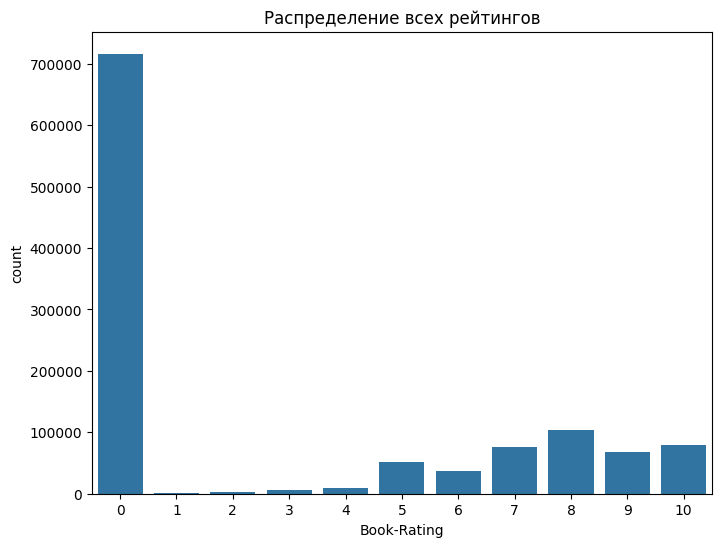

In [48]:
# Распределение всех рейтингов stat="percent"
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings)
plt.title("Распределение всех рейтингов")
plt.show()

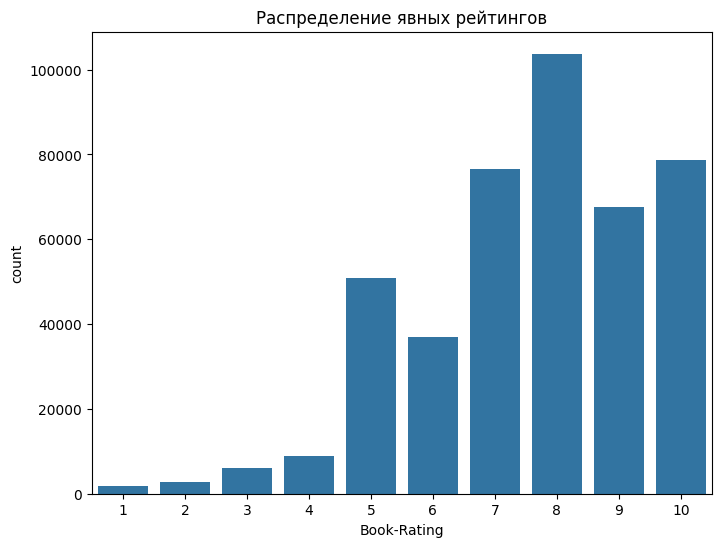

In [49]:
# Распределение явных рейтингов
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Распределение явных рейтингов")
plt.show()

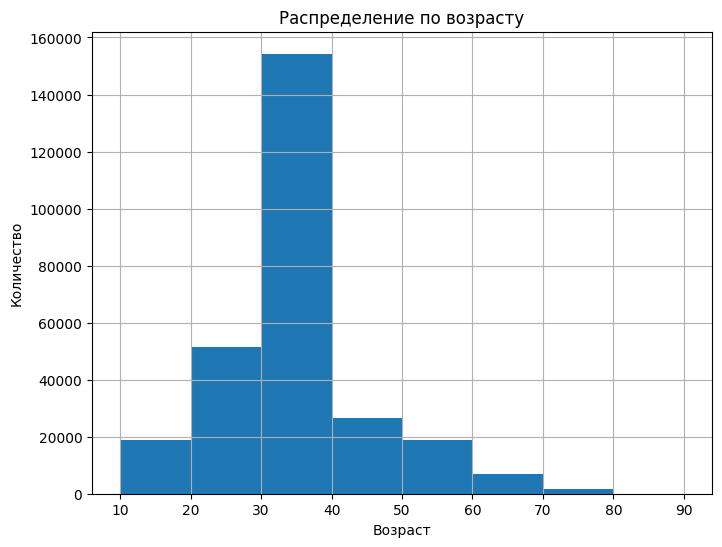

In [50]:
# Распределение возрастов пользователей
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

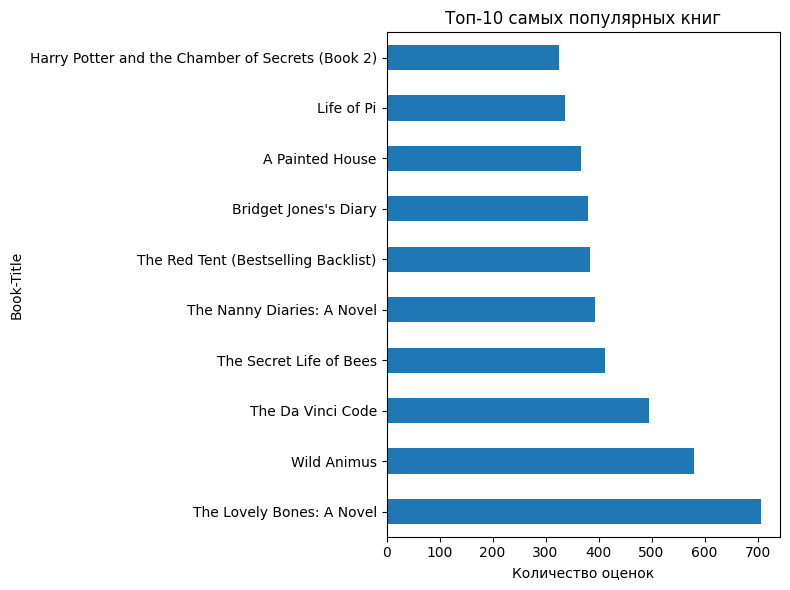

In [51]:
# Топ-10 самых популярных книг
plt.figure(figsize=(8, 6))
top_books = dataset1['Book-Title'].value_counts().head(10)
top_books.plot(kind='barh')
plt.title('Топ-10 самых популярных книг')
plt.xlabel('Количество оценок')

plt.tight_layout()
plt.show()

# Рекомендательная система

# Коллаборативная фильтрация



Рекомендации по совместной фильтрации пользователей и товаров

Система рекомендаций на основе совместной фильтрации учитывает оценки пользователей и находит косинусное сходство в оценках нескольких пользователей, чтобы рекомендовать книги. Для этого мы взяли только те книги, у которых не менее 50 оценок.



In [52]:
dataset1.shape

(384074, 11)

In [53]:
"""
Рекомендации по совместной фильтрации пользователей и товаров

Система рекомендаций на основе совместной фильтрации учитывает оценки пользователей и находит косинусное сходство в оценках нескольких пользователей, чтобы рекомендовать книги. Для этого мы взяли только те книги, у которых не менее 50 оценок.

"""

# Берём только явные рейтинги (не 0)
explicit_ratings = dataset1.copy()

book_counts = explicit_ratings['Book-Title'].value_counts()
user_counts = explicit_ratings['User-ID'].value_counts()

# книги, оценённые >=50 раз
# пользователей, поставивших >=20 оценок
filtered_books = book_counts[book_counts >= 50].index
filtered_users = user_counts[user_counts >= 20].index

cf_data = explicit_ratings[
    (explicit_ratings['Book-Title'].isin(filtered_books)) &
    (explicit_ratings['User-ID'].isin(filtered_users))
].copy()

print(f"Размер данных после фильтрации: {cf_data.shape}")

Размер данных после фильтрации: (30539, 11)


In [54]:
# Группируем по ISBN и Book-Title (на случай дубликатов ISBN с разными названиями), удаляю дубликаты оценок одного пользователя одной книги
cf_data = cf_data.drop_duplicates(subset=['ISBN', 'User-ID'])

# Создаём сводную таблицу: строки — книги (ISBN), столбцы — пользователи, значения — рейтинги
book_user_matrix = cf_data.pivot_table(
    index='ISBN',
    columns='User-ID',
    values='Book-Rating',
    fill_value=0
)

# Создаёт матрицу "книга * пользователь", где:
# строки — ISBN книг
# столбцы — ID пользователей
# значения — оценки (0, если не оценивал)
print(f"Матрица: {book_user_matrix.shape}")

Матрица: (1703, 2978)


In [55]:
# Преобразуем в разреженную матрицу
book_sparse = csr_matrix(book_user_matrix.values)

# Вычисляем косинусное сходство
book_similarity = cosine_similarity(book_sparse)
book_similarity_df = pd.DataFrame(
    book_similarity,
    index=book_user_matrix.index,
    columns=book_user_matrix.index
)

In [56]:
def get_book_title(isbn):
    # Возвращает название книги по ISBN из исходного датасета
    titles = books[books['ISBN'] == isbn]['Book-Title'].values
    if len(titles) > 0:
        return titles[0]
    else:
        return f"Unknown Book (ISBN: {isbn})"

def recommend_books_by_isbn(target_isbn, n_recommendations=5):
    if target_isbn not in book_similarity_df.index:
        print(f"Книга с ISBN {target_isbn} не найдена в данных для рекомендаций.")
        return []

    # Получаем сходства для целевой книги
    similar_books = book_similarity_df[target_isbn].sort_values(ascending=False)

    # Исключаем саму книгу (сходство = 1.0)
    similar_books = similar_books.iloc[1:]

    # Берём топ-N
    top_books = similar_books.head(n_recommendations)

    print(f"\nРекомендации для книги:\n'{get_book_title(target_isbn)}' (ISBN: {target_isbn})\n")
    recommendations = []
    for isbn, score in top_books.items():
        title = get_book_title(isbn)
        print(f"- {title} (сходство: {score:.3f})")
        recommendations.append((isbn, title, score))

    return recommendations

In [57]:
# Поиск ISBN по названию книги (регистронезависимо, частичное совпадение)
def find_isbn_by_title(title, books_df, threshold=0.6):
    """
    Ищет ISBN по названию книги.
    Возвращает первый найденный ISBN или None.
    """
    # Приводим к нижнему регистру для сравнения
    title_lower = title.lower()
    matches = books_df[books_df['Book-Title'].str.lower().str.contains(title_lower, na=False)]

    if len(matches) == 0:
        print(f"Книга с названием '{title}' не найдена.")
        return None

    # Берём первую найденную (можно улучшить: по автору, году и т.д.)
    isbn = matches.iloc[0]['ISBN']
    print(f"Найдена книга: '{matches.iloc[0]['Book-Title']}' (ISBN: {isbn})")
    return isbn


target_title = "Harry Potter and the Sorcerer's Stone"
target_isbn = find_isbn_by_title(target_title, books)

if target_isbn:
    recommendations = recommend_books_by_isbn(target_isbn, n_recommendations=5)

Найдена книга: 'Harry Potter and the Sorcerer's Stone (Book 1)' (ISBN: 0590353403)

Рекомендации для книги:
'Harry Potter and the Sorcerer's Stone (Book 1)' (ISBN: 0590353403)

- Harry Potter and the Chamber of Secrets (Book 2) (сходство: 0.651)
- Harry Potter and the Prisoner of Azkaban (Book 3) (сходство: 0.588)
- Harry Potter and the Goblet of Fire (Book 4) (сходство: 0.455)
- Harry Potter and the Order of the Phoenix (Book 5) (сходство: 0.331)
- The Fellowship of the Ring (The Lord of the Rings, Part 1) (сходство: 0.165)


In [58]:
# Выберем случайную книгу из данных
sample_isbn = cf_data['ISBN'].sample(1).values[0]
recommendations = recommend_books_by_isbn(sample_isbn, n_recommendations=5)


Рекомендации для книги:
'The Book of Ruth (Oprah's Book Club (Paperback))' (ISBN: 0385265700)

- STONES FROM THE RIVER (сходство: 0.242)
- Here on Earth (сходство: 0.213)
- Empire Falls (сходство: 0.172)
- The Reader (сходство: 0.169)
- Hearts in Atlantis (сходство: 0.167)


# Оценка и интерпретация результатов

In [83]:
def evaluate_recommendations_corrected():
    train_data, test_data = train_test_split(cf_data, test_size=0.2, random_state=42)

    train_matrix = train_data.pivot_table(
        index='ISBN',
        columns='User-ID',
        values='Book-Rating',
        fill_value=0
    )

    train_sparse = csr_matrix(train_matrix.values)
    train_similarity = cosine_similarity(train_sparse)

    hits = 0
    total_recommendations = 0
    actual_positives = 0

    for user_id in test_data['User-ID'].unique():
        user_test_books = test_data[test_data['User-ID'] == user_id]['ISBN'].tolist()

        user_train_books = train_data[train_data['User-ID'] == user_id]['ISBN'].tolist()

        if len(user_train_books) < 1 or len(user_test_books) < 1:
            continue

        all_recommendations = set()

        for known_book in user_train_books[:3]:
            if known_book in train_matrix.index:
                similar_books = pd.Series(
                    train_similarity[train_matrix.index.get_loc(known_book)],
                    index=train_matrix.index
                ).sort_values(ascending=False)

                recommendations = [
                    isbn for isbn in similar_books.index[1:6]
                    if isbn not in user_train_books
                ]
                all_recommendations.update(recommendations)

        final_recommendations = list(all_recommendations)[:5]

        if not final_recommendations:
            continue

        hits_user = len(set(final_recommendations) & set(user_test_books))

        hits += hits_user
        total_recommendations += len(final_recommendations)
        actual_positives += len(user_test_books)

    # Вычисление метрик
    precision = hits / total_recommendations if total_recommendations > 0 else 0
    recall = hits / actual_positives if actual_positives > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # print(f"Оценено пользователей: {len(test_data['User-ID'].unique())}")
    print(f"Precision: {precision*100:.4f}%")
    print(f"Recall: {recall*100:.4f}%")
    print(f"F1-Score: {f1*100:.4f}%")
    # print(f"Hit пользователей: {hits}")
    # print(f"Всего рекомендаций: {total_recommendations}")
    # print(f"Всего тестовых книг: {actual_positives}")

    return precision, recall, f1

print("Оценка модели:")
corrected_precision, corrected_recall, corrected_f1 = evaluate_recommendations_corrected()

Оценка модели:
Precision: 1.7033%
Recall: 2.9353%
F1-Score: 2.1557%


In [61]:
"""
Harry Potter and the Sorcerer's Stone
The Lovely Bones: A Novel
Wild Animus
The Da Vinci Code
Divine Secrets of the Ya-Ya Sisterhood: A Novel
Inscrutable Americans
Secret Island / Secret Mountain (Two-in-ones)
Pride and Prejudice (Dover Thrift Editions)
Skin And Bones
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Chamber of Secrets (Book 2)
The Hobbit
Fahrenheit 451
Twilight
The Bean Trees
The Metamorphosis (Bantam Classics)
The High King (Chronicles of Prydain (Paperback))
The Cat in the Hat
"""

"\nHarry Potter and the Sorcerer's Stone\nThe Lovely Bones: A Novel\nWild Animus\nThe Da Vinci Code\nDivine Secrets of the Ya-Ya Sisterhood: A Novel\nInscrutable Americans\nSecret Island / Secret Mountain (Two-in-ones)\nPride and Prejudice (Dover Thrift Editions)\nSkin And Bones\nHarry Potter and the Goblet of Fire (Book 4)\nHarry Potter and the Order of the Phoenix (Book 5)\nHarry Potter and the Chamber of Secrets (Book 2)\nThe Hobbit\nFahrenheit 451\nTwilight\nThe Bean Trees\nThe Metamorphosis (Bantam Classics)\nThe High King (Chronicles of Prydain (Paperback))\nThe Cat in the Hat\n"